In [2]:
import numpy as np
import pandas as pd
import glob
from sklearn import linear_model, metrics
import scipy.optimize
import random
from math import exp
from math import log
import random
from matplotlib import pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('data/train.csv', index_col=None, header=0)
df_test = pd.read_csv('data/test.csv', index_col=None, header=0)

In [5]:
### HOT ENCODING ###
for i in range(0,9):
  if i==7:
    continue
  featureName = 'X'+str(i)
  for c in df[featureName].unique():
    df[featureName+c] = np.where(df[featureName]==c, 1, 0)
  #df = df.drop(featureName,1)

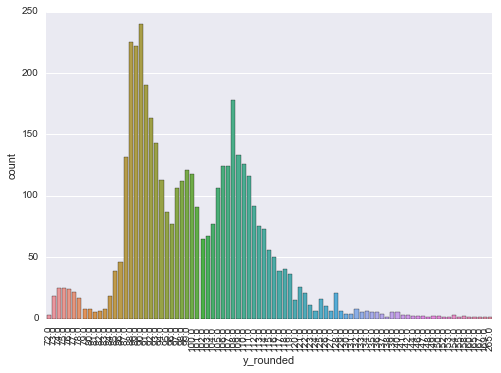

In [17]:
### Plot for the distribution of y ###
sns.plt.cla()
df['y_rounded'] = df['y'].astype(int)/1000
df['y_rounded'] = df['y_rounded']*1000
y_dist = sns.countplot(x='y_rounded',data=df)
for item in y_dist.get_xticklabels():
  item.set_rotation(90)
sns.plt.show()

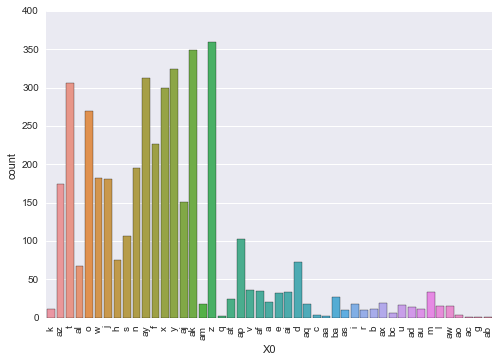

In [20]:
### Plot for the 
sns.plt.cla()
index = ['X0','X1','X2','X3','X3','X4','X5','X6','X8']
x_category = sns.countplot(x=index[0],data=df)
for item in x_category.get_xticklabels():
  item.set_rotation(90)
sns.plt.show()